# Analyse Cifar100 runs using Adam optimizer with various batch sizes
## Time to get to accuracy 0.6 on DL server

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from matplotlib import cm
import pandas as pd
import subprocess
import os
from cycler import cycler

In [40]:
logdir="logs/flextime/0_6x100/02_Adam/experiment02"

In [41]:
!ls logs/flextime/0_6x100/02_Adam/experiment02

cifar_adam_flextime_b1024.log cifar_adam_flextime_b384.log
cifar_adam_flextime_b128.log  cifar_adam_flextime_b48.log
cifar_adam_flextime_b1280.log cifar_adam_flextime_b512.log
cifar_adam_flextime_b1536.log cifar_adam_flextime_b64.log
cifar_adam_flextime_b16.log   cifar_adam_flextime_b640.log
cifar_adam_flextime_b24.log   cifar_adam_flextime_b768.log
cifar_adam_flextime_b256.log  cifar_adam_flextime_b8.log
cifar_adam_flextime_b32.log   cifar_adam_flextime_b80.log


In [42]:
filename_pattern=re.compile(r"cifar_.*\.log")

In [43]:
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))

In [44]:
batch_pattern = re.compile(r"^b\s*(\d+)")
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")

In [45]:
remove_str="[J"
def readfile(filename,debug=False):
    filename = filename.strip(" \n")
    with open(filename,"r") as f:
        lines = f.readlines()
        batch = 0
        epoch = 0    
        run = 0
        loss = 0
        acc = 0
        time = 0
        df = pd.DataFrame(data=None,columns=["batch","loss","acc","time","epochs"])
        for line in lines:
            s = line.strip('\n')
            s = s.replace(remove_str,"")
            #if debug: print line[:75]
            m = batch_pattern.match(s)        
            if m:
                batch = int(m.group(1))       
                epoch = 0
                run += 1
                if debug: print "New run with:",batch
            else:
                m = output_pattern.match(s)
                if m:
                    epoch = int(m.group(1))                    
                    loss = float(m.group(3))
                    acc = float(m.group(5))
                    time = float(m.group(6))
                    ls = [batch,loss,acc,time,epoch]
                    s = pd.Series([batch,loss,acc,time,epoch], index=["batch","loss","acc","time","epochs"])
                    #if debug: print s.T
                    df = df.append(s,ignore_index=True)
    if debug: print df
    return df

In [46]:
df = pd.DataFrame(data=None,columns=["batch","loss","acc","time","epochs"])
for file in files:
#print files[2]
    df1 = readfile(file)
    #print df1.head()
    if len(df1) > 0:
        df = pd.concat([df,df1],ignore_index=True)
df.iloc[60:70]

,batch,loss,acc,time,epochs
60,1024.0,1.78063,0.583801,1427.4900,61.0
61,1024.0,1.84325,0.574585,1450.8200,62.0
62,1024.0,1.77051,0.587946,1474.1400,63.0
63,1024.0,1.70412,0.598754,1497.0100,64.0
64,1024.0,1.77905,0.583891,1520.3400,65.0
65,1024.0,1.72381,0.592718,1543.6700,66.0
66,1024.0,1.69868,0.601782,1567.0100,67.0
67,128.0,4.62171,0.009889,27.6263,1.0
68,128.0,4.32724,0.030459,54.0723,2.0
69,128.0,4.06333,0.050732,80.8227,3.0


batch
8.0       AxesSubplot(0.125,0.125;0.775x0.755)
16.0      AxesSubplot(0.125,0.125;0.775x0.755)
24.0      AxesSubplot(0.125,0.125;0.775x0.755)
32.0      AxesSubplot(0.125,0.125;0.775x0.755)
48.0      AxesSubplot(0.125,0.125;0.775x0.755)
64.0      AxesSubplot(0.125,0.125;0.775x0.755)
80.0      AxesSubplot(0.125,0.125;0.775x0.755)
128.0     AxesSubplot(0.125,0.125;0.775x0.755)
256.0     AxesSubplot(0.125,0.125;0.775x0.755)
384.0     AxesSubplot(0.125,0.125;0.775x0.755)
512.0     AxesSubplot(0.125,0.125;0.775x0.755)
640.0     AxesSubplot(0.125,0.125;0.775x0.755)
768.0     AxesSubplot(0.125,0.125;0.775x0.755)
1024.0    AxesSubplot(0.125,0.125;0.775x0.755)
1280.0    AxesSubplot(0.125,0.125;0.775x0.755)
1536.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

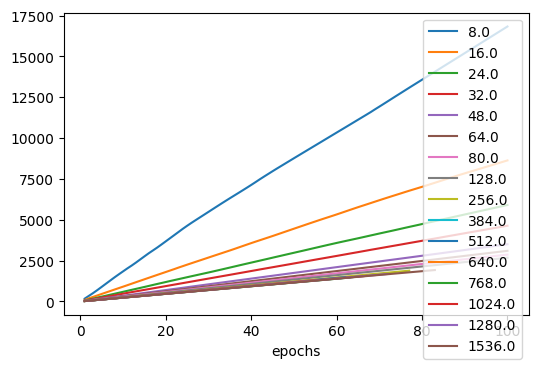

In [48]:
df_batches = df.copy()
df_batches.set_index("epochs",inplace=True)
df_batches.groupby(by="batch")["time"].plot(legend=True)

Text(0,0.5,u'Time (s)')

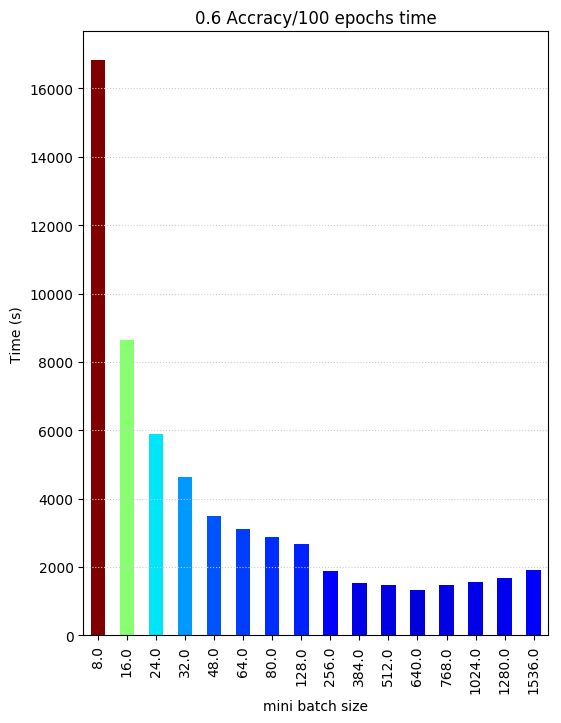

In [265]:
fig, ax = plt.subplots(figsize=(6,8))
max_times = df.groupby(by="batch")["time"].max()
#print type(max_times)
colors = cm.jet(max_times.values / float(max_times.max()))
max_times.plot.bar(ax=ax,color=colors,title="0.6 Accracy/100 epochs time")
ax.yaxis.grid(linestyle=":",color="#cccccc")
ax.set_xlabel("mini batch size")
ax.set_ylabel("Time (s)")
#ax.set_facecolor("#F7FEEB")

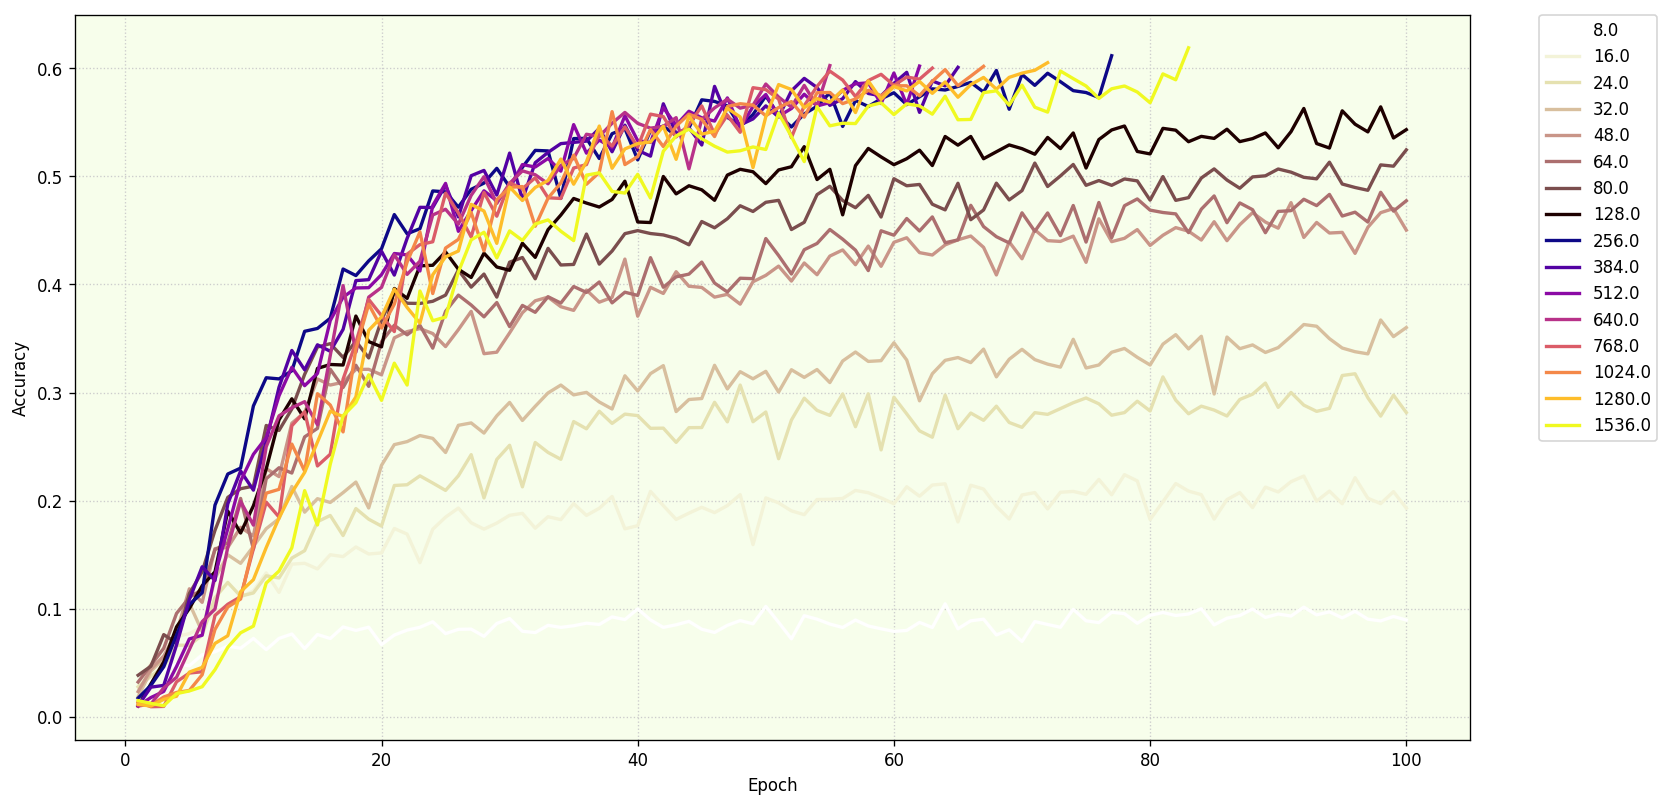

In [256]:
#marker_style = dict(markersize=1, markerfacecolor='w')
#plt.rc('axes', prop_cycle=(matplotlib.cycler('linestyle', ['-'])))
#plt.rc('axes', prop_cycle=(matplotlib.cycler('marker', ['o', 's'])))
colors=itertools.chain(iter(cm.pink_r(np.linspace(0,1,8))),iter(cm.plasma(np.linspace(0,1,8))))
fig,ax = plt.subplots(figsize=(15,8),dpi=120)
#ax.set_prop_cycle(cycler("marker",['o','s','d','o','s','d']) + cycler("linestyle",['-',':','-',':','-',':']))
df.pivot(index="epochs", columns="batch", values="acc").plot(ax=ax,linewidth=2, color=colors)#,
                                                            # fillstyle='full', **marker_style)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., )
plt.grid(linestyle=":",color="#cccccc")
#axs = fig.axes[0]
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_facecolor("#F7FEEB")

In [54]:
df.pivot(index="epochs", columns="batch", values="acc").head()

batch,8.0,16.0,24.0,32.0,48.0,64.0,80.0,128.0,256.0,384.0,512.0,640.0,768.0,1024.0,1280.0,1536.0
epochs,,,,,,,,,,,,,,,,
1.0,0.0278,0.0284,0.027628,0.018670,0.023325,0.032146,0.0384,0.009889,0.017285,0.010320,0.010110,0.009941,0.013672,0.013317,0.011418,0.014921
2.0,0.0347,0.0491,0.037470,0.042133,0.044059,0.047671,0.0468,0.030459,0.029102,0.027392,0.017802,0.011836,0.009301,0.010493,0.009923,0.012432
3.0,0.0432,0.0628,0.046263,0.053814,0.056220,0.063396,0.0760,0.050732,0.046289,0.029032,0.023455,0.026777,0.009580,0.018274,0.016106,0.010197
4.0,0.0488,0.0743,0.066247,0.080970,0.077651,0.095641,0.0683,0.083169,0.075488,0.066454,0.046507,0.036504,0.032366,0.022473,0.018960,0.021405
5.0,0.0472,0.0769,0.066147,0.104932,0.118421,0.110370,0.1139,0.100178,0.103906,0.108410,0.072024,0.062207,0.040458,0.024342,0.041361,0.023916


In [114]:
df_times = df.copy()

In [115]:
print df_times.columns
df_times.set_index("time",inplace=True)
df_times.head()

Index([u'batch', u'loss', u'acc', u'time', u'epochs'], dtype='object')


,batch,loss,acc,epochs
time,,,,
24.1878,1024.0,4.60610,0.013317,1.0
47.6043,1024.0,4.92029,0.010493,2.0
71.1511,1024.0,4.92356,0.018274,3.0
94.7235,1024.0,4.65935,0.022473,4.0
118.3490,1024.0,4.88286,0.024342,5.0


In [190]:
df_times_gr = df_times.groupby(by="batch")["acc"]
#for key, item in df_times_gr:    
#    print key, df_times_gr.get_group(key), "\n\n"

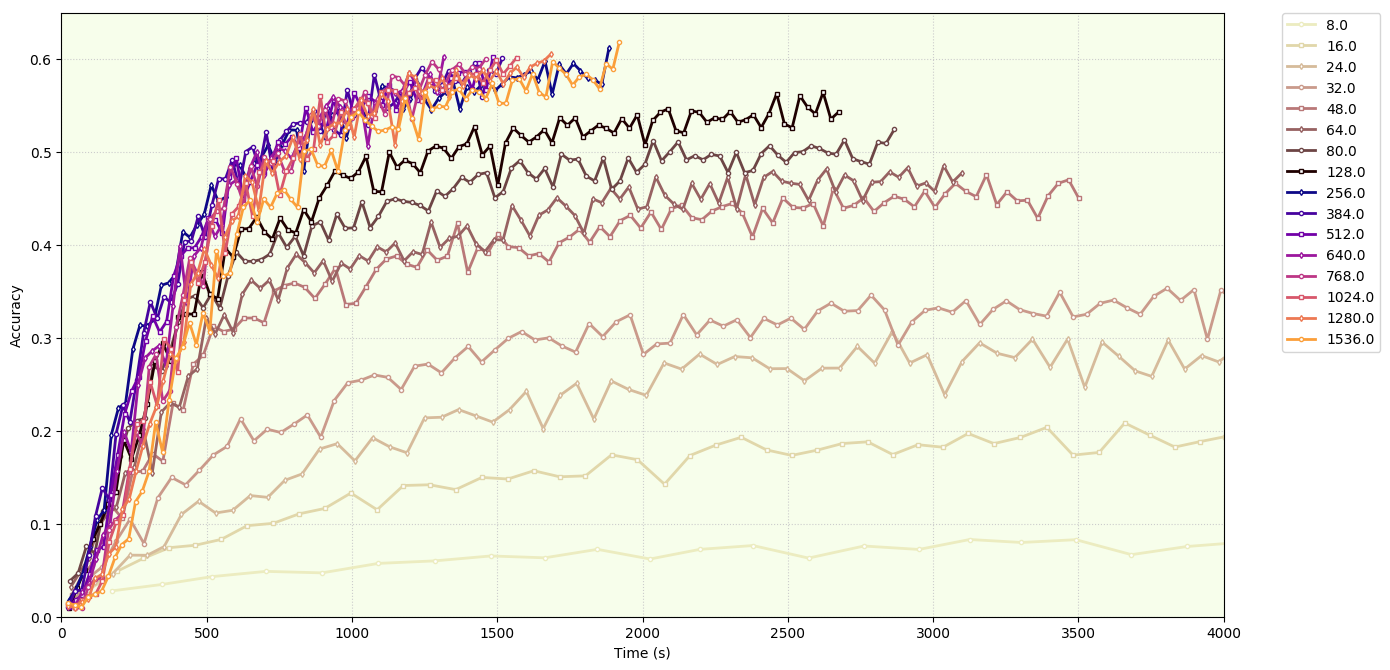

In [264]:
marker_style = dict(markersize=3, markerfacecolor='w')
colors = itertools.chain(iter(cm.pink_r(np.linspace(0,1,10)[2:])),iter(cm.plasma(np.linspace(0,1,10)[:-2])))
fig,ax = plt.subplots(figsize=(15,8))
ax.set_prop_cycle(cycler("marker",['o','s','d','o','s','d']))# + cycler("linestyle",['-',':','-',':','-',':']))
for key, item in df_times_gr:
    df_ = df_times_gr.get_group(key)
    color = matplotlib.colors.to_rgba(colors.next())
    df_.plot(ax=ax, color=color,linewidth=2, fillstyle='full',label=key,**marker_style)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle=":",color="#cccccc")
#ax = fig.axes[0]
ax.set_xlim(0,4000)
ax.set_ylim(0,0.65)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Accuracy")
ax.set_facecolor("#F7FEEB")
    

In [248]:
def convertRGBAColors(colors_arr):
    tuples = []
    for ar in colors_arr:
        col = matplotlib.colors.to_rgba(ar)
        tuples.append(col)
    return tuples

ValueError: Invalid color argument: ''

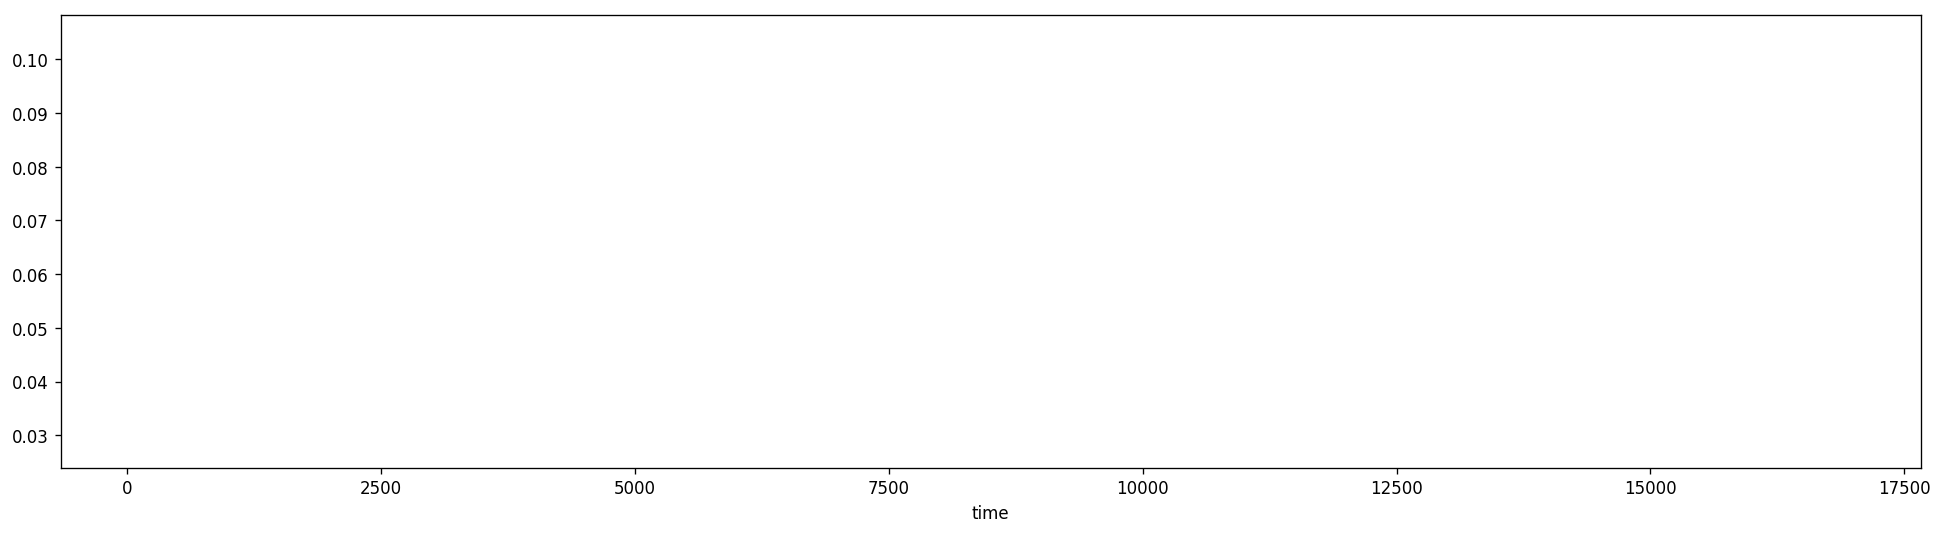

In [249]:
marker_style = dict(markersize=5, markerfacecolor='w')
colors = itertools.chain(
    iter(convertRGBAColors(cm.pink_r(np.linspace(0,1,8)))),
    iter(convertRGBAColors(cm.plasma(np.linspace(0,1,8)))))
print colors
#colors = convertRGBAColors(colors)
#print colors
fig,ax = plt.subplots(figsize=(20,5),dpi=120)
ax.set_prop_cycle(cycler("marker",['o','s','d','o','s','d']) + cycler("linestyle",['-',':','-',':','-',':']))
df_times.groupby(by="batch")["acc"].plot(ax=ax, kind="line", linewidth=1, 
                                         fillstyle='full',color = colors,
                                          **marker_style)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle=":",color="#cccccc")
axs = fig.axes[0]
axs.set_facecolor("#F7FEEB")

In [ ]:
df_batches = df.copy()
df_batches.set_index("epochs",inplace=True)
df_batches.groupby(by="batch")["acc"].plot(legend=True)

In [ ]:
loss_df = df_reach[['batch','loss']]
acc_df = df[['batch','acc']]
time_df = df_reach[['batch','time']]
epoch_df = df_reach[['batch','epochs']]

In [ ]:
time_df = df_reach[['batch','time']]
time_df.sort_values(by="batch").plot(kind="bar",x="batch")

In [ ]:
loss_df.sort_values(by="batch").plot(kind="bar",x="batch")

In [ ]:
acc_df.sort_values(by="batch").plot(kind="bar",x="batch")

In [ ]:
df.head()

In [11]:
print(plt.style.available)

[u'seaborn-darkgrid', u'Solarize_Light2', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'fast', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


In [34]:
print plt.style.library['Solarize_Light2']

axes.axisbelow: True
axes.edgecolor: #eee8d5
axes.facecolor: #eee8d5
axes.grid: True
axes.labelcolor: #657b83
axes.labelsize: 12.0
axes.prop_cycle: cycler(u'color', [u'#268BD2', u'#2AA198', u'#859900', u'#B58900', u'#CB4B16', u'#DC322F', u'#D33682', u'#6C71C4'])
axes.titlesize: 16.0
figure.facecolor: #FDF6E3
grid.color: #fdf6e3
grid.linestyle: -
grid.linewidth: 1.0
lines.linewidth: 2.0
lines.solid_capstyle: butt
patch.antialiased: True
xtick.color: #657b83
xtick.direction: out
ytick.color: #657b83
ytick.direction: out


In [12]:
print matplotlib.lines.Line2D.fillStyles

(u'full', u'left', u'right', u'bottom', u'top', u'none')
